# Import libraries

In [1]:
import sys
sys.path.append('../')
%matplotlib inline

In [2]:
from utils.utils import calc_AUC
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import utils.hsdmdl2_nml as hsdmdl2_nml
import utils.hsdmdl1_nml as hsdmdl1_nml
import utils.sdmdl_nml as sdmdl_nml
import tsmdl.aw2s_mdl as aw2s_mdl
import tsmdl.fw2s_mdl as fw2s_mdl
import dmdl.hsdmdl2 as hsdmdl2
import dmdl.hsdmdl1 as hsdmdl1
import dmdl.sdmdl as sdmdl
from functools import partial
import pandas as pd
import optuna
import changefinder
import bocpd
import datetime as dt

/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
def estimate_changepoints(scores, threshold):
    alarms = np.where(scores >= threshold)[0]

    return alarms

# Data preparation

In [4]:
# data frame
df = pd.read_csv('../data/dow-jones-closing.csv')
# starting and ending date
start_date = dt.datetime(1972, 7, 5)
end_date = dt.datetime(1975, 6, 30)
df['Date'] = pd.to_datetime(df['Date'])
#df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

df['Rate'] = 0
for i in range(1, len(df)):
    df.iloc[i, 2] = (df.iloc[i, 1]/df.iloc[i-1, 1])-1

df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
df = df.reset_index(drop=True)

# starting points of gradual changes
cp1 = dt.datetime(1973, 1, 30)
cp2 = dt.datetime(1973, 10, 19)
cp3 = dt.datetime(1974, 8, 9)


# 1) the conviction of G. Gordon Liddy and James W. McCord, Jr. in the Watergate incident on January 30, 1973
# 2) the declaration of the oil embargo by the Organization of Petroleum Exporting Countries (OPEC) against the United States on October 19, 1973
# 3) the resignation of President Nixon on August 9, 1974.
cp1_index = len(df[df['Date'] <= cp1])
cp2_index = len(df[df['Date'] <= cp2])
cp3_index = len(df[df['Date'] <= cp3])
changepoints = [cp1_index, cp2_index, cp3_index]

# Change or change sign score calculation

In [5]:
# parameters
tolerance_delay = 25
n_trials = 100
both = True

In [6]:
# BOCPD
def _objective_BOCPD(trial, train, changepoints, tolerance_delay):
    lam = trial.suggest_int('lam', 2,100)
    alpha = trial.suggest_uniform('alpha', 1e-8, 10)
    beta = trial.suggest_uniform('beta', 1e-8, 0.001)
    kappa = trial.suggest_uniform('kappa', 1e-8, 0.001)
    mu=0
    #mu = trial.suggest_uniform('mu', -1, 1)

    h = partial(bocpd.constant_hazard, lam)
    lik = bocpd.StudentT(alpha, beta, kappa, mu)
    retrospective = bocpd.Retrospective(hazard_func=h, likelihood_func=lik)

    scores = retrospective.calc_scores(train)
    AUC = calc_AUC(scores, changepoints, tolerance_delay, both=both)

    return -AUC


# hyperparameter tuning
objective_BOCPD = partial(_objective_BOCPD, train=np.array(df['Rate']),
                          changepoints=changepoints, tolerance_delay=tolerance_delay)
study = optuna.create_study()
study.optimize(objective_BOCPD, n_trials=n_trials)

# calculate scores
opt_lam = study.best_params['lam']
opt_alpha = study.best_params['alpha']
opt_beta = study.best_params['beta']
opt_kappa = study.best_params['kappa']
#opt_mu = study.best_params['mu']
opt_mu=0

h = partial(bocpd.constant_hazard, opt_lam)
lik = bocpd.StudentT(opt_alpha, opt_beta, opt_kappa, opt_mu)
retrospective = bocpd.Retrospective(hazard_func=h, likelihood_func=lik)

bocpd_scores = retrospective.calc_scores(np.array(df['Rate']))

[I 2021-02-22 18:24:55,010] Finished a trial resulted in value: -0.49302222222222214. Current best value is -0.49302222222222214 with parameters: {'lam': 51, 'alpha': 7.611183895799992, 'beta': 0.00020331389532687194, 'kappa': 0.0002274729704603866}.
[I 2021-02-22 18:24:55,195] Finished a trial resulted in value: -0.5791782222222224. Current best value is -0.5791782222222224 with parameters: {'lam': 6, 'alpha': 6.504600269001586, 'beta': 0.0004406744213503041, 'kappa': 0.0007895411295697984}.
[I 2021-02-22 18:24:55,380] Finished a trial resulted in value: -0.4218177777777776. Current best value is -0.5791782222222224 with parameters: {'lam': 6, 'alpha': 6.504600269001586, 'beta': 0.0004406744213503041, 'kappa': 0.0007895411295697984}.
[I 2021-02-22 18:24:55,568] Finished a trial resulted in value: -0.4012653333333333. Current best value is -0.5791782222222224 with parameters: {'lam': 6, 'alpha': 6.504600269001586, 'beta': 0.0004406744213503041, 'kappa': 0.0007895411295697984}.
[I 2021-

[I 2021-02-22 18:25:01,499] Finished a trial resulted in value: -0.3883439999999999. Current best value is -0.5943808888888893 with parameters: {'lam': 5, 'alpha': 5.805737948981349, 'beta': 0.0003966786095050825, 'kappa': 0.0009897759674399778}.
[I 2021-02-22 18:25:01,703] Finished a trial resulted in value: -0.6329848888888888. Current best value is -0.6329848888888888 with parameters: {'lam': 3, 'alpha': 9.127652289306482, 'beta': 0.0004216010915220686, 'kappa': 0.0007890437058163467}.
[I 2021-02-22 18:25:01,912] Finished a trial resulted in value: -0.40244355555555533. Current best value is -0.6329848888888888 with parameters: {'lam': 3, 'alpha': 9.127652289306482, 'beta': 0.0004216010915220686, 'kappa': 0.0007890437058163467}.
[I 2021-02-22 18:25:02,127] Finished a trial resulted in value: -0.5066622222222225. Current best value is -0.6329848888888888 with parameters: {'lam': 3, 'alpha': 9.127652289306482, 'beta': 0.0004216010915220686, 'kappa': 0.0007890437058163467}.
[I 2021-02-

[I 2021-02-22 18:25:08,597] Finished a trial resulted in value: -0.5488102222222221. Current best value is -0.6329848888888888 with parameters: {'lam': 3, 'alpha': 9.127652289306482, 'beta': 0.0004216010915220686, 'kappa': 0.0007890437058163467}.
[I 2021-02-22 18:25:08,817] Finished a trial resulted in value: -0.589146222222222. Current best value is -0.6329848888888888 with parameters: {'lam': 3, 'alpha': 9.127652289306482, 'beta': 0.0004216010915220686, 'kappa': 0.0007890437058163467}.
[I 2021-02-22 18:25:09,035] Finished a trial resulted in value: -0.4100822222222222. Current best value is -0.6329848888888888 with parameters: {'lam': 3, 'alpha': 9.127652289306482, 'beta': 0.0004216010915220686, 'kappa': 0.0007890437058163467}.
[I 2021-02-22 18:25:09,252] Finished a trial resulted in value: -0.5395271111111106. Current best value is -0.6329848888888888 with parameters: {'lam': 3, 'alpha': 9.127652289306482, 'beta': 0.0004216010915220686, 'kappa': 0.0007890437058163467}.
[I 2021-02-22

[I 2021-02-22 18:25:15,989] Finished a trial resulted in value: -0.3696404444444442. Current best value is -0.6332675555555565 with parameters: {'lam': 4, 'alpha': 8.551847113001742, 'beta': 0.000450177551033049, 'kappa': 0.0008331454341388025}.


In [7]:
# CF
def _objective_CF(trial, train, changepoints, tolerance_delay):
    # hyperparameters
    r = trial.suggest_uniform('r', 0.01, 0.99)
    order = trial.suggest_int('order', 1, 20)
    smooth = trial.suggest_int('smooth', 3, 20)

    retrospective = changefinder.Retrospective(r=r, order=order, smooth=smooth)
    scores = retrospective.calc_scores(train)
    AUC = calc_AUC(
        scores, changepoints, tolerance_delay, both=both)
    return -AUC


# hyperparameter tuning
objective_CF = partial(_objective_CF, train=np.array(df['Rate']),
                       changepoints=changepoints, tolerance_delay=tolerance_delay)
study = optuna.create_study()
study.optimize(objective_CF, n_trials=n_trials, n_jobs=-1)
opt_r = study.best_params['r']
opt_order = study.best_params['order']
opt_smooth = study.best_params['smooth']

retrospective = changefinder.Retrospective(
    r=opt_r, order=opt_order, smooth=opt_smooth)

cf_scores = retrospective.calc_scores(np.array(df['Rate']))

[I 2021-02-22 18:25:20,607] Finished a trial resulted in value: -0.6599239999999997. Current best value is -0.6599239999999997 with parameters: {'r': 0.5573626186368764, 'order': 3, 'smooth': 10}.
[I 2021-02-22 18:25:20,619] Finished a trial resulted in value: -0.6530897777777771. Current best value is -0.6599239999999997 with parameters: {'r': 0.5573626186368764, 'order': 3, 'smooth': 10}.
[I 2021-02-22 18:25:20,621] Finished a trial resulted in value: -0.3702573333333334. Current best value is -0.6599239999999997 with parameters: {'r': 0.5573626186368764, 'order': 3, 'smooth': 10}.
[I 2021-02-22 18:25:20,936] Finished a trial resulted in value: -0.44864533333333345. Current best value is -0.6599239999999997 with parameters: {'r': 0.5573626186368764, 'order': 3, 'smooth': 10}.
[I 2021-02-22 18:25:20,944] Finished a trial resulted in value: -0.46408444444444447. Current best value is -0.6599239999999997 with parameters: {'r': 0.5573626186368764, 'order': 3, 'smooth': 10}.
[I 2021-02-22

[I 2021-02-22 18:25:38,915] Finished a trial resulted in value: -0.7025417777777774. Current best value is -0.773206222222222 with parameters: {'r': 0.366116416333912, 'order': 17, 'smooth': 6}.
[I 2021-02-22 18:25:39,079] Finished a trial resulted in value: -0.5198973333333338. Current best value is -0.773206222222222 with parameters: {'r': 0.366116416333912, 'order': 17, 'smooth': 6}.
[I 2021-02-22 18:25:39,095] Finished a trial resulted in value: -0.6346106666666663. Current best value is -0.773206222222222 with parameters: {'r': 0.366116416333912, 'order': 17, 'smooth': 6}.
[I 2021-02-22 18:25:39,681] Finished a trial resulted in value: -0.6196480000000005. Current best value is -0.773206222222222 with parameters: {'r': 0.366116416333912, 'order': 17, 'smooth': 6}.
[I 2021-02-22 18:25:41,291] Finished a trial resulted in value: -0.6769693333333335. Current best value is -0.773206222222222 with parameters: {'r': 0.366116416333912, 'order': 17, 'smooth': 6}.
[I 2021-02-22 18:25:41,52

[I 2021-02-22 18:25:55,160] Finished a trial resulted in value: -0.47181555555555516. Current best value is -0.773206222222222 with parameters: {'r': 0.366116416333912, 'order': 17, 'smooth': 6}.
[I 2021-02-22 18:25:55,340] Finished a trial resulted in value: -0.5156431111111095. Current best value is -0.773206222222222 with parameters: {'r': 0.366116416333912, 'order': 17, 'smooth': 6}.
[I 2021-02-22 18:25:56,329] Finished a trial resulted in value: -0.5093617777777774. Current best value is -0.773206222222222 with parameters: {'r': 0.366116416333912, 'order': 17, 'smooth': 6}.
[I 2021-02-22 18:25:56,343] Finished a trial resulted in value: -0.5927448888888891. Current best value is -0.773206222222222 with parameters: {'r': 0.366116416333912, 'order': 17, 'smooth': 6}.
[I 2021-02-22 18:25:56,378] Finished a trial resulted in value: -0.42874666666666694. Current best value is -0.773206222222222 with parameters: {'r': 0.366116416333912, 'order': 17, 'smooth': 6}.
[I 2021-02-22 18:25:56,

In [8]:
# SDMDL 0th
def _objective_SDMDL(trial, train, changepoints, tolerance_delay, params):
    nml_gaussian = partial(sdmdl_nml.nml_gaussian, mu_max=params[
                           "mu_max"], div_min=params["div_min"], div_max=params["div_max"])
    complexity_gaussian = partial(sdmdl_nml.complexity_gaussian, mu_max=params[
                                  "mu_max"], div_min=params["div_min"], div_max=params["div_max"])
    window_size = trial.suggest_int('window_size', 5, 60)
    retrospective = sdmdl.Retrospective(h=window_size, encoding_func=nml_gaussian,
                                        complexity_func=complexity_gaussian, order=params["order"])

    scores = retrospective.calc_scores(train)
    n = len(scores)
    scores[2*window_size-1: n] = scores[window_size-1: n-window_size]
    scores[0:2*window_size] = np.nan

    AUC = calc_AUC(scores, changepoints,  tolerance_delay, both=both)
    return -AUC


mu_max = 10
div_min = 1e-2
div_max = 1e2
params = {"mu_max": mu_max, "div_min": div_min,
          "div_max": div_max, "order": 0}

# 0th D-MDL
# hyperparameter tuning
objective_SDMDL = partial(_objective_SDMDL, train=np.array(df['Rate']),
                          changepoints=changepoints, tolerance_delay=tolerance_delay, params=params)
study = optuna.create_study()
study.optimize(objective_SDMDL, n_trials=n_trials, n_jobs=-1)
opt_window_size = study.best_params['window_size']

nml_gaussian = partial(sdmdl_nml.nml_gaussian, mu_max=params["mu_max"],
                       div_min=params["div_min"], div_max=params["div_max"])
complexity_gaussian = partial(sdmdl_nml.complexity_gaussian, mu_max=params["mu_max"],
                              div_min=params["div_min"], div_max=params["div_max"])
retrospective = sdmdl.Retrospective(h=opt_window_size, encoding_func=nml_gaussian,
                                    complexity_func=complexity_gaussian, order=params["order"])

sdmdl_0_scores = retrospective.calc_scores(np.array(df['Rate']))
n = len(sdmdl_0_scores)
sdmdl_0_scores[2*opt_window_size -
               1: n] = sdmdl_0_scores[opt_window_size-1: n-opt_window_size]
sdmdl_0_scores[0:2*opt_window_size] = np.nan

# 1st D-MDL
params = {"mu_max": mu_max, "div_min": div_min,
          "div_max": div_max, "order": 1}
# hyperparameter tuning
objective_SDMDL = partial(_objective_SDMDL, train=np.array(df['Rate']),
                          changepoints=changepoints, tolerance_delay=tolerance_delay, params=params)
study = optuna.create_study()
study.optimize(objective_SDMDL, n_trials=n_trials, n_jobs=-1)
opt_window_size = study.best_params['window_size']

nml_gaussian = partial(sdmdl_nml.nml_gaussian, mu_max=params["mu_max"],
                       div_min=params["div_min"], div_max=params["div_max"])
complexity_gaussian = partial(sdmdl_nml.complexity_gaussian, mu_max=params["mu_max"],
                              div_min=params["div_min"], div_max=params["div_max"])
retrospective = sdmdl.Retrospective(h=opt_window_size, encoding_func=nml_gaussian,
                                    complexity_func=complexity_gaussian, order=params["order"])

sdmdl_1_scores = retrospective.calc_scores(np.array(df['Rate']))
n = len(sdmdl_1_scores)
sdmdl_1_scores[2*opt_window_size -
               1: n] = sdmdl_1_scores[opt_window_size-1: n-opt_window_size]
sdmdl_1_scores[0:2*opt_window_size] = np.nan

# 2nd D-MDL
params = {"mu_max": mu_max, "div_min": div_min,
          "div_max": div_max, "order": 2}
# hyperparameter tuning
objective_SDMDL = partial(_objective_SDMDL, train=np.array(df['Rate']),
                          changepoints=changepoints, tolerance_delay=tolerance_delay, params=params)
study = optuna.create_study()
study.optimize(objective_SDMDL, n_trials=n_trials, n_jobs=-1)
opt_window_size = study.best_params['window_size']

nml_gaussian = partial(sdmdl_nml.nml_gaussian, mu_max=params["mu_max"],
                       div_min=params["div_min"], div_max=params["div_max"])
complexity_gaussian = partial(sdmdl_nml.complexity_gaussian, mu_max=params["mu_max"],
                              div_min=params["div_min"], div_max=params["div_max"])
retrospective = sdmdl.Retrospective(h=opt_window_size, encoding_func=nml_gaussian,
                                    complexity_func=complexity_gaussian, order=params["order"])

sdmdl_2_scores = retrospective.calc_scores(np.array(df['Rate']))
n = len(sdmdl_2_scores)
sdmdl_2_scores[2*opt_window_size -
               1: n] = sdmdl_2_scores[opt_window_size-1: n-opt_window_size]
sdmdl_2_scores[0:2*opt_window_size] = np.nan

[I 2021-02-22 18:26:00,283] Finished a trial resulted in value: -0.5809035555555557. Current best value is -0.5809035555555557 with parameters: {'window_size': 35}.
[I 2021-02-22 18:26:00,288] Finished a trial resulted in value: -0.6353546666666666. Current best value is -0.6353546666666666 with parameters: {'window_size': 23}.
[I 2021-02-22 18:26:00,293] Finished a trial resulted in value: -0.6514657777777773. Current best value is -0.6514657777777773 with parameters: {'window_size': 30}.
[I 2021-02-22 18:26:00,298] Finished a trial resulted in value: -0.4883786666666666. Current best value is -0.6514657777777773 with parameters: {'window_size': 30}.
[I 2021-02-22 18:26:00,304] Finished a trial resulted in value: -0.47887911111111114. Current best value is -0.6514657777777773 with parameters: {'window_size': 30}.
[I 2021-02-22 18:26:00,321] Finished a trial resulted in value: -0.4656946666666669. Current best value is -0.6514657777777773 with parameters: {'window_size': 30}.
[I 2021-0

[I 2021-02-22 18:26:10,208] Finished a trial resulted in value: -0.641544888888889. Current best value is -0.6553653333333339 with parameters: {'window_size': 29}.
[I 2021-02-22 18:26:10,217] Finished a trial resulted in value: -0.6553653333333339. Current best value is -0.6553653333333339 with parameters: {'window_size': 29}.
[I 2021-02-22 18:26:10,415] Finished a trial resulted in value: -0.6411982222222223. Current best value is -0.6553653333333339 with parameters: {'window_size': 29}.
[I 2021-02-22 18:26:10,535] Finished a trial resulted in value: -0.6499266666666673. Current best value is -0.6553653333333339 with parameters: {'window_size': 29}.
[I 2021-02-22 18:26:10,699] Finished a trial resulted in value: -0.6399986666666665. Current best value is -0.6553653333333339 with parameters: {'window_size': 29}.
[I 2021-02-22 18:26:11,093] Finished a trial resulted in value: -0.6486115555555548. Current best value is -0.6553653333333339 with parameters: {'window_size': 29}.
[I 2021-02-

[I 2021-02-22 18:26:17,509] Finished a trial resulted in value: -0.6353546666666666. Current best value is -0.6553653333333339 with parameters: {'window_size': 29}.
[I 2021-02-22 18:26:17,519] Finished a trial resulted in value: -0.636481777777777. Current best value is -0.6553653333333339 with parameters: {'window_size': 29}.
[I 2021-02-22 18:26:20,797] Finished a trial resulted in value: -0.5960040000000001. Current best value is -0.5960040000000001 with parameters: {'window_size': 35}.
[I 2021-02-22 18:26:20,808] Finished a trial resulted in value: -0.5942800000000004. Current best value is -0.5960040000000001 with parameters: {'window_size': 35}.
[I 2021-02-22 18:26:20,827] Finished a trial resulted in value: -0.5977008888888888. Current best value is -0.5977008888888888 with parameters: {'window_size': 21}.
[I 2021-02-22 18:26:20,919] Finished a trial resulted in value: -0.5959635555555556. Current best value is -0.5977008888888888 with parameters: {'window_size': 21}.
[I 2021-02-

[I 2021-02-22 18:26:29,560] Finished a trial resulted in value: -0.6027253333333338. Current best value is -0.6062022222222229 with parameters: {'window_size': 39}.
[I 2021-02-22 18:26:29,885] Finished a trial resulted in value: -0.6062022222222229. Current best value is -0.6062022222222229 with parameters: {'window_size': 39}.
[I 2021-02-22 18:26:30,061] Finished a trial resulted in value: -0.5959635555555556. Current best value is -0.6062022222222229 with parameters: {'window_size': 39}.
[I 2021-02-22 18:26:30,525] Finished a trial resulted in value: -0.6026466666666663. Current best value is -0.6062022222222229 with parameters: {'window_size': 39}.
[I 2021-02-22 18:26:30,737] Finished a trial resulted in value: -0.5959635555555556. Current best value is -0.6062022222222229 with parameters: {'window_size': 39}.
[I 2021-02-22 18:26:30,741] Finished a trial resulted in value: -0.5935253333333329. Current best value is -0.6062022222222229 with parameters: {'window_size': 39}.
[I 2021-02

[I 2021-02-22 18:26:37,656] Finished a trial resulted in value: -0.5924124444444451. Current best value is -0.6062057777777778 with parameters: {'window_size': 38}.
[I 2021-02-22 18:26:37,670] Finished a trial resulted in value: -0.6011591111111114. Current best value is -0.6062057777777778 with parameters: {'window_size': 38}.
[I 2021-02-22 18:26:37,678] Finished a trial resulted in value: -0.5941493333333329. Current best value is -0.6062057777777778 with parameters: {'window_size': 38}.
[I 2021-02-22 18:26:37,685] Finished a trial resulted in value: -0.5988733333333335. Current best value is -0.6062057777777778 with parameters: {'window_size': 38}.
[I 2021-02-22 18:26:40,900] Finished a trial resulted in value: -0.5591031111111113. Current best value is -0.5591031111111113 with parameters: {'window_size': 36}.
[I 2021-02-22 18:26:40,909] Finished a trial resulted in value: -0.5124315555555555. Current best value is -0.5591031111111113 with parameters: {'window_size': 36}.
[I 2021-02

[I 2021-02-22 18:26:48,953] Finished a trial resulted in value: -0.5648066666666661. Current best value is -0.6095266666666662 with parameters: {'window_size': 59}.
[I 2021-02-22 18:26:49,116] Finished a trial resulted in value: -0.5627017777777774. Current best value is -0.6095266666666662 with parameters: {'window_size': 59}.
[I 2021-02-22 18:26:49,406] Finished a trial resulted in value: -0.5652906666666666. Current best value is -0.6095266666666662 with parameters: {'window_size': 59}.
[I 2021-02-22 18:26:49,637] Finished a trial resulted in value: -0.5627017777777774. Current best value is -0.6095266666666662 with parameters: {'window_size': 59}.
[I 2021-02-22 18:26:49,769] Finished a trial resulted in value: -0.5544760000000005. Current best value is -0.6095266666666662 with parameters: {'window_size': 59}.
[I 2021-02-22 18:26:49,912] Finished a trial resulted in value: -0.5648066666666661. Current best value is -0.6095266666666662 with parameters: {'window_size': 59}.
[I 2021-02

[I 2021-02-22 18:26:56,997] Finished a trial resulted in value: -0.6044151111111112. Current best value is -0.6095266666666662 with parameters: {'window_size': 59}.
[I 2021-02-22 18:26:57,007] Finished a trial resulted in value: -0.523020888888889. Current best value is -0.6095266666666662 with parameters: {'window_size': 59}.
[I 2021-02-22 18:26:57,035] Finished a trial resulted in value: -0.6077906666666668. Current best value is -0.6095266666666662 with parameters: {'window_size': 59}.
[I 2021-02-22 18:26:57,055] Finished a trial resulted in value: -0.5287120000000001. Current best value is -0.6095266666666662 with parameters: {'window_size': 59}.
[I 2021-02-22 18:26:57,061] Finished a trial resulted in value: -0.5730333333333336. Current best value is -0.6095266666666662 with parameters: {'window_size': 59}.
[I 2021-02-22 18:26:57,067] Finished a trial resulted in value: -0.6077906666666668. Current best value is -0.6095266666666662 with parameters: {'window_size': 59}.


In [9]:
# FW2S_MDL
def _objective_FW2S_MDL(trial, train, changepoints, tolerance_delay, params):
    nml_gaussian = partial(sdmdl_nml.nml_gaussian, mu_max=params[
                           "mu_max"], div_min=params["div_min"], div_max=params["div_max"])
    complexity_gaussian = partial(sdmdl_nml.complexity_gaussian, mu_max=params[
                                  "mu_max"], div_min=params["div_min"], div_max=params["div_max"])
    delta_0 = trial.suggest_uniform('delta_0', 0.001, 0.499)
    window_size_1 = trial.suggest_int('window_size_1', 5, 60)
    window_size_2 = trial.suggest_int('window_size_2', 5, 60)

    retrospective_first = sdmdl.Retrospective(h=window_size_1, encoding_func=nml_gaussian,
                                              complexity_func=complexity_gaussian, delta_0=delta_0, order=0)
    retrospective_second = sdmdl.Retrospective(h=window_size_2, encoding_func=nml_gaussian,
                                               complexity_func=complexity_gaussian, order=0)
    retrospective = fw2s_mdl.Retrospective(
        retrospective_first, retrospective_second)
    scores = retrospective.calc_scores(train)

    n = len(scores)
    scores[2*(window_size_1+window_size_2): n] = scores[window_size_1 +
                                                        window_size_2: n-(window_size_1+window_size_2)]
    scores[0:2*(window_size_1+window_size_2)] = np.nan

    AUC = calc_AUC(scores, changepoints,  tolerance_delay, both=both)
    return -AUC

mu_max = 10
div_min = 1e-2
div_max = 1e2
params = {"mu_max": mu_max, "div_min": div_min,
          "div_max": div_max}

# hyperparameter tuning
objective_FW2S_MDL = partial(_objective_FW2S_MDL, train=np.array(df['Rate']),
                             changepoints=changepoints, tolerance_delay=tolerance_delay, params=params)
study = optuna.create_study()
study.optimize(objective_FW2S_MDL, n_trials=n_trials, n_jobs=-1)
opt_delta_0 = study.best_params['delta_0']
opt_window_size_1 = study.best_params['window_size_1']
opt_window_size_2 = study.best_params['window_size_2']

nml_gaussian = partial(sdmdl_nml.nml_gaussian, mu_max=params["mu_max"],
                       div_min=params["div_min"], div_max=params["div_max"])
complexity_gaussian = partial(sdmdl_nml.complexity_gaussian, mu_max=params["mu_max"],
                              div_min=params["div_min"], div_max=params["div_max"])

retrospective_first = sdmdl.Retrospective(h=opt_window_size_1, encoding_func=nml_gaussian,
                                          complexity_func=complexity_gaussian, delta_0=opt_delta_0, order=0)
retrospective_second = sdmdl.Retrospective(h=opt_window_size_2, encoding_func=nml_gaussian,
                                           complexity_func=complexity_gaussian, order=0)
retrospective = fw2s_mdl.Retrospective(
    retrospective_first, retrospective_second)

fw2s_mdl_scores = retrospective.calc_scores(np.array(df['Rate']))
n = len(fw2s_mdl_scores)
fw2s_mdl_scores[2*(opt_window_size_1+opt_window_size_2): n] = fw2s_mdl_scores[opt_window_size_1 +
                                                                              opt_window_size_2: n-(opt_window_size_1+opt_window_size_2)]
fw2s_mdl_scores[0:2*(opt_window_size_1+opt_window_size_2)] = np.nan

[I 2021-02-22 18:27:02,981] Finished a trial resulted in value: -0.7919204444444449. Current best value is -0.7919204444444449 with parameters: {'delta_0': 0.43481103993957954, 'window_size_1': 19, 'window_size_2': 34}.
[I 2021-02-22 18:27:02,985] Finished a trial resulted in value: -0.6147688888888888. Current best value is -0.7919204444444449 with parameters: {'delta_0': 0.43481103993957954, 'window_size_1': 19, 'window_size_2': 34}.
[I 2021-02-22 18:27:02,988] Finished a trial resulted in value: -0.6874559999999997. Current best value is -0.7919204444444449 with parameters: {'delta_0': 0.43481103993957954, 'window_size_1': 19, 'window_size_2': 34}.
[I 2021-02-22 18:27:02,992] Finished a trial resulted in value: -0.6369382222222222. Current best value is -0.7919204444444449 with parameters: {'delta_0': 0.43481103993957954, 'window_size_1': 19, 'window_size_2': 34}.
[I 2021-02-22 18:27:03,090] Finished a trial resulted in value: -0.625005333333333. Current best value is -0.79192044444

[I 2021-02-22 18:27:16,704] Finished a trial resulted in value: -0.7454808888888884. Current best value is -0.8813088888888886 with parameters: {'delta_0': 0.34715235402381606, 'window_size_1': 9, 'window_size_2': 60}.
[I 2021-02-22 18:27:17,115] Finished a trial resulted in value: -0.5052919999999995. Current best value is -0.8813088888888886 with parameters: {'delta_0': 0.34715235402381606, 'window_size_1': 9, 'window_size_2': 60}.
[I 2021-02-22 18:27:17,148] Finished a trial resulted in value: -0.4989693333333329. Current best value is -0.8813088888888886 with parameters: {'delta_0': 0.34715235402381606, 'window_size_1': 9, 'window_size_2': 60}.
[I 2021-02-22 18:27:17,417] Finished a trial resulted in value: -0.4995928888888892. Current best value is -0.8813088888888886 with parameters: {'delta_0': 0.34715235402381606, 'window_size_1': 9, 'window_size_2': 60}.
[I 2021-02-22 18:27:17,838] Finished a trial resulted in value: -0.5046924444444446. Current best value is -0.88130888888888

[I 2021-02-22 18:27:30,480] Finished a trial resulted in value: -0.5319813333333324. Current best value is -0.8813088888888886 with parameters: {'delta_0': 0.34715235402381606, 'window_size_1': 9, 'window_size_2': 60}.
[I 2021-02-22 18:27:30,668] Finished a trial resulted in value: -0.5229315555555559. Current best value is -0.8813088888888886 with parameters: {'delta_0': 0.34715235402381606, 'window_size_1': 9, 'window_size_2': 60}.
[I 2021-02-22 18:27:31,555] Finished a trial resulted in value: -0.529277777777777. Current best value is -0.8813088888888886 with parameters: {'delta_0': 0.34715235402381606, 'window_size_1': 9, 'window_size_2': 60}.
[I 2021-02-22 18:27:31,854] Finished a trial resulted in value: -0.8817213333333338. Current best value is -0.8817213333333338 with parameters: {'delta_0': 0.42684093368787546, 'window_size_1': 10, 'window_size_2': 55}.
[I 2021-02-22 18:27:31,908] Finished a trial resulted in value: -0.8380733333333331. Current best value is -0.88172133333333

# Draw a graph

SDMDL 0th:  0.6553653333333339
SDMDL 1st:  0.6062057777777778
SDMDL 2nd:  0.6095266666666662
FW2S-MDL:  0.9045639999999998
ChangeFinder:  0.7816248888888888
BOCPD:  0.6332675555555565


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

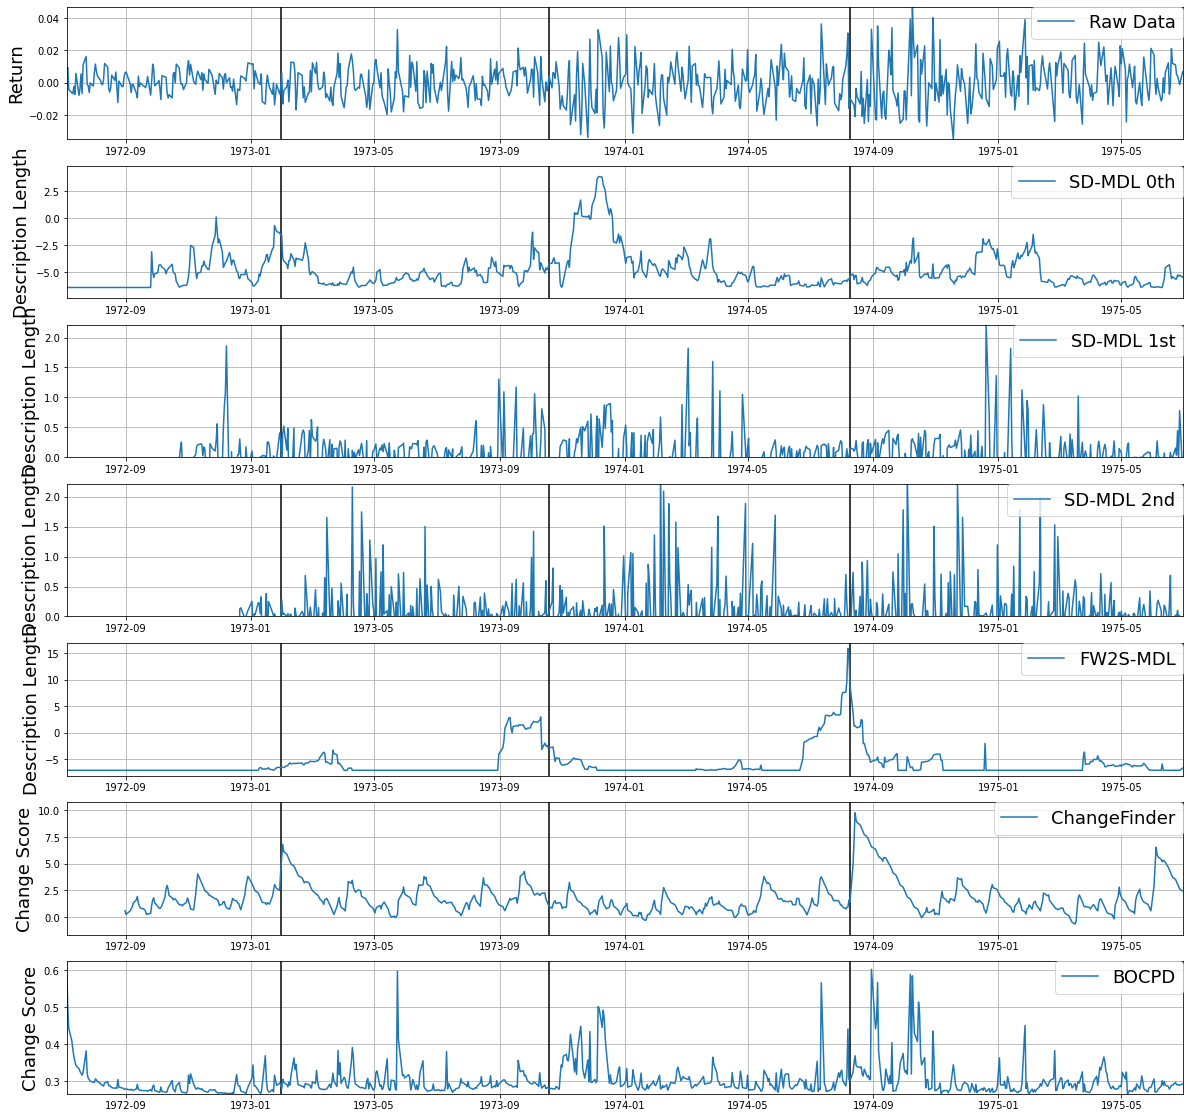

In [10]:
sdmdl_0_scores[np.isnan(sdmdl_0_scores)] = np.nanmin(sdmdl_0_scores)
sdmdl_1_scores[np.isnan(sdmdl_1_scores)] = np.nanmin(sdmdl_1_scores)
sdmdl_2_scores[np.isnan(sdmdl_2_scores)] = np.nanmin(sdmdl_2_scores)
fw2s_mdl_scores[np.isnan(fw2s_mdl_scores)] = np.nanmin(fw2s_mdl_scores)

print("SDMDL 0th: ", calc_AUC(sdmdl_0_scores,
                              changepoints,  tolerance_delay, both=both))
print("SDMDL 1st: ", calc_AUC(sdmdl_1_scores,
                              changepoints,  tolerance_delay, both=both))
print("SDMDL 2nd: ", calc_AUC(sdmdl_2_scores,
                              changepoints,  tolerance_delay, both=both))
print("FW2S-MDL: ", calc_AUC(fw2s_mdl_scores,
                             changepoints,  tolerance_delay, both=both))
print("ChangeFinder: ", calc_AUC(
    cf_scores, changepoints,  tolerance_delay, both=both))
print("BOCPD: ", calc_AUC(bocpd_scores, changepoints,  tolerance_delay, both=both))


plt.clf()
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(20, 20))

fontsize = 18

axes[0].plot(df['Date'], df['Rate'], label='Raw Data')
axes[0].set_ylabel('Return', fontsize=fontsize)
axes[0].vlines([cp1, cp2, cp3], -100, 100, color="black")
axes[0].set_ylim(np.min(df['Rate']), np.max(df['Rate']))
axes[0].legend(bbox_to_anchor=(1, 1), loc='upper right',
               borderaxespad=0, fontsize=fontsize)
axes[0].set_xlim(start_date, end_date)
axes[0].grid(True)

axes[1].plot(df['Date'], sdmdl_0_scores, label='SD-MDL 0th')
axes[1].set_ylabel('Description Length', fontsize=fontsize)
axes[1].vlines([cp1, cp2, cp3], -100, 100, color="black")
axes[1].set_ylim(np.nanmin(sdmdl_0_scores)-1, np.nanmax(sdmdl_0_scores)+1)
axes[1].legend(bbox_to_anchor=(1, 1), loc='upper right',
               borderaxespad=0, fontsize=fontsize)
axes[1].set_xlim(start_date, end_date)
axes[1].grid(True)

axes[2].plot(df['Date'], sdmdl_1_scores, label='SD-MDL 1st')
axes[2].set_ylabel('Description Length', fontsize=fontsize)
axes[2].vlines([cp1, cp2, cp3], -100, 100, color="black")
axes[2].set_ylim(0, np.nanmax(sdmdl_1_scores))
axes[2].legend(bbox_to_anchor=(1, 1), loc='upper right',
               borderaxespad=0, fontsize=fontsize)
axes[2].set_xlim(start_date, end_date)
axes[2].grid(True)

axes[3].plot(df['Date'], sdmdl_2_scores, label='SD-MDL 2nd')
axes[3].set_ylabel('Description Length', fontsize=fontsize)
axes[3].vlines([cp1, cp2, cp3], -100, 100, color="black")
axes[3].set_ylim(0, np.nanmax(sdmdl_1_scores))
axes[3].legend(bbox_to_anchor=(1, 1), loc='upper right',
               borderaxespad=0, fontsize=fontsize)
axes[3].set_xlim(start_date, end_date)
axes[3].grid(True)


axes[4].plot(df['Date'], fw2s_mdl_scores, label='FW2S-MDL')
axes[4].set_ylabel('Description Length', fontsize=fontsize)
axes[4].vlines([cp1, cp2, cp3], -100, 100, color="black")
axes[4].set_ylim(np.nanmin(fw2s_mdl_scores)-1, np.nanmax(fw2s_mdl_scores)+1)
axes[4].legend(bbox_to_anchor=(1, 1), loc='upper right',
               borderaxespad=0, fontsize=fontsize)
axes[4].set_xlim(start_date, end_date)
axes[4].grid(True)

axes[5].plot(df['Date'], cf_scores, label='ChangeFinder')
axes[5].set_ylabel('Change Score', fontsize=fontsize)
axes[5].vlines([cp1, cp2, cp3], -100, 100, color="black")
axes[5].set_ylim(np.nanmin(cf_scores)-1, np.nanmax(cf_scores)+1)
axes[5].legend(bbox_to_anchor=(1, 1), loc='upper right',
               borderaxespad=0, fontsize=fontsize)
axes[5].set_xlim(start_date, end_date)
axes[5].grid(True)

axes[6].plot(df['Date'], bocpd_scores, label='BOCPD')
axes[6].set_ylabel('Change Score', fontsize=fontsize)
axes[6].vlines([cp1, cp2, cp3], -100, 100, color="black")
axes[6].set_ylim(np.nanmin(bocpd_scores), np.nanmax(bocpd_scores))
axes[6].legend(bbox_to_anchor=(1, 1), loc='upper right',
               borderaxespad=0, fontsize=fontsize)
axes[6].set_xlim(start_date, end_date)
axes[6].grid(True)